*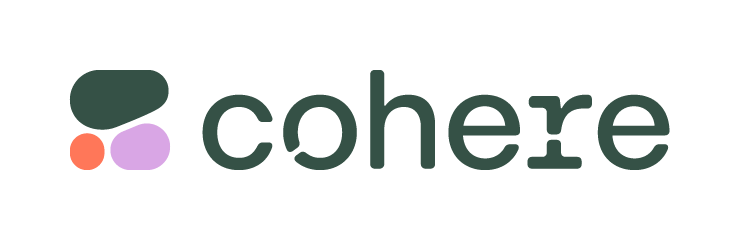*

In [ ]:
%%capture
!pip install cohere
!pip install -qU langchain-text-splitters
!pip install llama-index-embeddings-cohere
!pip install llama-index-postprocessor-cohere-rerank

In [ ]:
import requests
from typing import List

from bs4 import BeautifulSoup

import cohere
from getpass import getpass
from IPython.display import HTML, display

from langchain_text_splitters import CharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter

from llama_index.core import Document
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core import VectorStoreIndex, ServiceContext

In [ ]:
# Set up Cohere client
co_model = 'command-r'
co_api_key = getpass("Enter Cohere API key: ")
co = cohere.Client(api_key=co_api_key)

Enter Cohere API key: ··········



# Introduction

Chunking is an essential component of any RAG-based system. This cookbook aims to demonstrate how different chunking strategies affect the results of LLM-generated output. There are multiple considerations that need to be taken into account when designing chunking strategy. Therefore, we begin by providing a framework for these strategies and then jump into a practical example. We will focus our example on transcript calls, which create a unique challenge because of their rich content and the change of people speaking throughout the text.

# Table of content

1. [Chunking Strategies Framework](#framework)
2. [Getting started](#getting-started)
3. [Example 1: Chunking using content-independent strategies](#example-1)
4. [Example 2: Chunking using content-dependent strategies](#example-2)
5. [Discussion](#discussion)

<a name="framework"></a>
# Chunking Strategies Framework

## Document splitting

By document splitting, we mean deciding on the conditions under which we will break the text. At this stage, we should ask, *"Are there any parts of consecutive text we want to ensure we do not break?"*. If the answer is "no", then, the content-independent splitting strategies are helpful. On the other hand, in scenarios like transcripts or meeting notes, we probably would like to keep the content of one speaker together, which might require us to deploy content-dependent strategies.

### Content-independent splitting strategies

We split the document based on some content-independent conditions, among the most popular ones are:
- splitting by the number of characters,
- splitting by sentence,
- splitting by a given character, for example, `\n` for paragraphs.

The advantage of this scenario is that we do not need to make any assumptions about the text. However, some considerations remain, like whether we want to preserve some semantic structure, for example, sentences or paragraphs. Sentence splitting is better suited if we are looking for small chunks to ensure accuracy. Conversely, paragraphs preserve more context and might be more useful in open-ended questions.

### Content-dependent splitting strategies

On the other hand, there are scenarios in which we care about preserving some text structure. Then, we develop custom splitting strategies based on the document's content. A prime example is call transcripts. In such scenarios, we aim to ensure that one person's speech is fully contained within a chunk.

## Creating chunks from the document splits

After the document is split, we need to decide on the desired **size** of our chunks (the split only defines how we break the document, but we can create bigger chunks from multiple splits).

Smaller chunks support more accurate retrieval. However, they might lack context. On the other hand, larger chunks offer more context, but they reduce the effectiveness of the retrieval. It is important to experiment with different settings to find the optimal balance.

## Overlapping chunks

Overlapping chunks is a useful technique to have in the toolbox. Especially when we employ content-independent splitting strategies, it helps us mitigate some of the pitfalls of breaking the document without fully understanding the text. Overlapping guarantees that there is always some buffer between the chunks, and even if an important piece of information might be split in the original splitting strategy, it is more probable that the full information will be captured in the next chunk. The disadvantage of this method is that it creates redundancy.

<a name="getting-stated"></a>
# Getting started

Designing a robust chunking strategy is as much a science as an art. There are no straightforward answers; the most effective strategies often emerge through experimentation. Therefore, let's dive straight into an example to illustrate this concept.







## Utils

In [ ]:
def set_css():
  display(HTML('''
  <style>/
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

set_css()

In [ ]:
def insert_citations(text: str, citations: List[dict]):
    """
    A helper function to pretty print citations.
    """
    offset = 0
    # Process citations in the order they were provided
    for citation in citations:
        # Adjust start/end with offset
        start, end = citation['start'] + offset, citation['end'] + offset
        placeholder = "[" + ", ".join(doc[4:] for doc in citation["document_ids"]) + "]"
        # ^ doc[4:] removes the 'doc_' prefix, and leaves the quoted document
        modification = f'{text[start:end]} {placeholder}'
        # Replace the cited text with its bolded version + placeholder
        text = text[:start] + modification + text[end:]
        # Update the offset for subsequent replacements
        offset += len(modification) - (end - start)

    return text

def build_retreiver(documents, top_n=5):
  # Create the embedding model
  embed_model = CohereEmbedding(
      cohere_api_key=co_api_key,
      model_name="embed-english-v3.0",
      input_type="search_query",
  )

  # Load the data, for this example data needs to be in a test file
  index = VectorStoreIndex.from_documents(
      documents,
      embed_model=embed_model
  )

  # Create a cohere reranker
  cohere_rerank = CohereRerank(api_key=co_api_key)

  # Create the retriever
  retriever = index.as_retriever(node_postprocessors=[cohere_rerank], similarity_top_k=top_n)
  return retriever

##Load the data

In this example we will work with an 2023 Tesla earning call transcript.

In [ ]:
# Get all investement memos (19) in bvp repository
url_path = 'https://www.fool.com/earnings/call-transcripts/2024/01/24/tesla-tsla-q4-2023-earnings-call-transcript/'
response = requests.get(url_path)
soup = BeautifulSoup(response.content, 'html.parser')

target_divs = soup.find("div", {"class": "article-body"}).find_all("p")[2:]
print('Length of the script: ', len(target_divs))

print()
print('Example of processed text:')
text = '\n\n'.join([div.get_text() for div in target_divs])
print(text[:500])

Length of the script:  385

Example of processed text:
Martin Viecha

Good afternoon, everyone, and welcome to Tesla's fourth-quarter 2023 Q&A webcast. My name is Martin Viecha, VP of investor relations, and I'm joined today by Elon Musk, Vaibhav Taneja, and a number of other executives. Our Q4 results were announced at about 3 p.m. Central Time in the update that we published at the same link as this webcast.

During this call, we will discuss our business outlook and make forward-looking statements. These comments are based on our predictions and 


<a name="example-1"></a>
# Example 1: Chunking using content-independent strategies

Let's begin with a simple content-independent strategy. We aim to answer the question, `Who mentiones Jonathan Nolan?`. We chose this question as it is easily verifiable and it requires to identify the speaker. The answer to this questions can be found in the dowloaded transcscript, here is the relevant passage:


```
Elon Musk -- Chief Executive Officer and Product Architect

Yeah. The creators of Westworld, Jonathan Nolan, Lisa Joy Nolan, are friends -- are all friends of mine, actually. And I invited them to come see the lab and, like, well, come see it, hopefully soon. It's pretty well -- especially the sort of subsystem test stands where you've just got like one leg on a test stand just doing repetitive exercises and one arm on a test stand pretty well.
```

In [ ]:
# Define the question
question = "Who mentiones Jonathan Nolan?"

In this case, we are more concerned about accuracy than a verbose answer, so we **focus on keeping the chunks small**. To ensure that the desired size is not exceeded, we will randomly split the list of characters, in our case `["\n\n", "\n", " ", ""]`.

We employ the `RecursiveCharacterTextSplitter` from [LangChain](https://python.langchain.com/docs/get_started/introduction) for this task.

In [ ]:
# Define the chunking function
def get_chunks(text, chunk_size, chunk_overlap):
  text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len,
    is_separator_regex=False,
  )

  documents = text_splitter.create_documents([text])
  documents = [Document(text=doc.page_content) for doc in documents]

  return documents

### Experiment 1 - no overlap
In our first experiment we define the chunk size as 500 and allow **no overlap between consecutive chunks**.

Subsequently, we implement the standard RAG pipeline. We feed the chunks into a retriever, selecting the `top_n` most pertinent to the query chunks, and supply them as context to the generation model. Throughout this pipeline, we leverage [Cohere's endpoints](https://docs.cohere.com/reference/about), specifically, `co.embed`, `co.re.rank`, and finally, `co.chat`.

In [ ]:
chunk_size = 500
chunk_overlap = 0
documents = get_chunks(text, chunk_size, chunk_overlap)
retriever = build_retreiver(documents)

source_nodes = retriever.retrieve(question)
print('Number of docuemnts: ',len(source_nodes))
source_nodes= [{"text": ni.get_content()}for ni in source_nodes]


response = co.chat(
  message=question,
  documents=source_nodes,
  model=co_model
)
response = response
print(response.text)

Number of docuemnts:  5
An unknown speaker mentions Jonathan Nolan in a conversation about the creators of Westworld. They mention that Jonathan Nolan and Lisa Joy Nolan are friends of theirs, and that they have invited them to visit the lab.


A notable feature of [`co.chat`](https://docs.cohere.com/reference/chat) is its ability to ground the model's answer within the context. This means we can identify which chunks were used to generate the answer. Below, we show the previous output of the model together with the citation reference, where `[num]` represents the index of the chunk.

In [ ]:
print(insert_citations(response.text, response.citations))

An unknown speaker [0] mentions Jonathan Nolan in a conversation about the creators of Westworld. [0] They mention that Jonathan Nolan and Lisa Joy Nolan [0] are friends [0] of theirs, and that they have invited them to visit the lab. [0]


Indeed, by printing the cited chunk, we can validate that the text was divided so that the generation model could not provide the correct response. Notably, the speaker's name is not included in the context, which is why the model refes to an `unknown speaker`.

In [ ]:
print(source_nodes[0])

{'text': "Yeah. The creators of Westworld, Jonathan Nolan, Lisa Joy Nolan, are friends -- are all friends of mine, actually. And I invited them to come see the lab and, like, well, come see it, hopefully soon. It's pretty well -- especially the sort of subsystem test stands where you've just got like one leg on a test stand just doing repetitive exercises and one arm on a test stand pretty well.\n\nYeah.\n\nUnknown speaker\n\nWe're not entering Westworld anytime soon."}


### Experiment 2 - allow overlap
In the previous experiment, we discovered that the chunks were generated in a way that made it impossible to generate the correct answer. The name of the speaker was not included in the relevant chunk.

Therefore, this time to mitigate this issue, we **allow for overlap between consecutive chunks**.

In [ ]:
chunk_size = 500
chunk_overlap = 100
documents = get_chunks(text,chunk_size, chunk_overlap)
retriever = build_retreiver(documents)

source_nodes = retriever.retrieve(question)
print('Number of docuemnts: ',len(source_nodes))
source_nodes= [{"text": ni.get_content()}for ni in source_nodes]


response = co.chat(
  message=question,
  documents=source_nodes,
  model=co_model
)
response = response
print(response.text)

Number of docuemnts:  5
Elon Musk mentions Jonathan Nolan. Musk is the CEO and Product Architect of the lab that resembles the set of Westworld, a show created by Jonathan Nolan and Lisa Joy Nolan.


Again, we can print the text along with the citations.

In [ ]:
print(insert_citations(response.text, response.citations))

Elon Musk [0] mentions Jonathan Nolan. Musk is the CEO and Product Architect [0] of the lab [0] that resembles the set of Westworld [0], a show created by Jonathan Nolan [0] and Lisa Joy Nolan. [0]


And investigate the chunks which were used as context to answer the query.



In [ ]:
source_nodes[0]

{'text': "Yeah, not the best reference.\n\nElon Musk -- Chief Executive Officer and Product Architect\n\nYeah. The creators of Westworld, Jonathan Nolan, Lisa Joy Nolan, are friends -- are all friends of mine, actually. And I invited them to come see the lab and, like, well, come see it, hopefully soon. It's pretty well -- especially the sort of subsystem test stands where you've just got like one leg on a test stand just doing repetitive exercises and one arm on a test stand pretty well.\n\nYeah."}

As we can see, by allowing overlap we managed to get the correct answer to our question.

<a name="example-2"></a>
# Example 2: Chunking using content-dependent strategies

In the previous experiment, we provided an example of how using or not using overlapping can affect a model's performance,  particularly in documents such as call transcripts where subjects change frequently. Ensuring that each chunk contains all relevant information is crucial. While we managed to retrieve the correct information by introducing overlapping into the chunking strategy, this might still not be the optimal approach for transcripts with longer speaker speeches.

Therefore, in this experiment, we will adopt a content-dependent strategy.

Our proposed approach entails segmenting the text whenever a new speaker begins speaking, which requires preprocessing the text accordingly.

### Preprocess the text

Firstly, let's observe that in the HTML text, each time the speaker changes, their name is enclosed within `<p><strong>Name</p></strong>` tags, denoting the speaker's name in bold letters.

To facilitate our text chunking process, we'll use the above observation and introduce a unique character sequence `###`, which we'll utilize as a marker for splitting the text.

In [ ]:
print('HTML text')
print(target_divs[:3])
print('-------------------\n')

text_custom = []
for div in target_divs:
  if div.get_text() is None:
    continue
  if str(div).startswith('<p><strong>'):
    text_custom.append(f'### {div.get_text()}')
  else:
    text_custom.append(div.get_text())

text_custom = '\n'.join(text_custom)
print(text_custom[:500])

HTML text
[<p><strong>Martin Viecha</strong></p>, <p>Good afternoon, everyone, and welcome to Tesla's fourth-quarter 2023 Q&amp;A webcast. My name is Martin Viecha, VP of investor relations, and I'm joined today by Elon Musk, Vaibhav Taneja, and a number of other executives. Our Q4 results were announced at about 3 p.m. Central Time in the update that we published at the same link as this webcast.</p>, <p>During this call, we will discuss our business outlook and make forward-looking statements. These comments are based on our predictions and expectations as of today. Actual events or results could differ materially due to a number of risks and uncertainties, including those mentioned in our most recent filings with the SEC. [Operator instructions] But before we jump into Q&amp;A, Elon has some opening remarks.</p>]
-------------------

### Martin Viecha
Good afternoon, everyone, and welcome to Tesla's fourth-quarter 2023 Q&A webcast. My name is Martin Viecha, VP of investor relations,

In this approach, we prioritize splitting the text at the appropriate separator, `###.` To ensure this behavior, we'll use `CharacterTextSplitter` from [LangChain](https://python.langchain.com/docs/get_started/introduction), guaranteeing such behavior. From our analysis of the text and the fact that we aim to preserve entire speaker speeches intact, we anticipate that most of them will exceed a length of 500. Hence, we'll increase the chunk size to 1000.

In [ ]:
separator = "###"
chunk_size = 1000
chunk_overlap = 0

text_splitter = CharacterTextSplitter(
    separator = separator,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len,
    is_separator_regex=False,
)

documents = text_splitter.create_documents([text_custom])
documents = [Document(text=doc.page_content) for doc in documents]

retriever = build_retreiver(documents)

source_nodes = retriever.retrieve(question)
print('Number of docuemnts: ',len(source_nodes))
source_nodes= [{"text": ni.get_content()}for ni in source_nodes]

response = co.chat(
  message=question,
  documents=source_nodes,
  model=co_model
)
response = response
print(response.text)

Number of docuemnts:  5
Elon Musk mentions Jonathan Nolan. Musk is friends with the creators of Westworld, Jonathan Nolan and Lisa Joy Nolan.


Below we validate the answer using citations.

In [ ]:
print(insert_citations(response.text, response.citations))

Elon Musk [0] mentions Jonathan Nolan. [0] Musk is friends [0] with the creators of Westworld [0], Jonathan Nolan [0] and Lisa Joy Nolan. [0]


In [ ]:
source_nodes[0]

{'text': "Elon Musk -- Chief Executive Officer and Product Architect\nYeah. The creators of Westworld, Jonathan Nolan, Lisa Joy Nolan, are friends -- are all friends of mine, actually. And I invited them to come see the lab and, like, well, come see it, hopefully soon. It's pretty well -- especially the sort of subsystem test stands where you've just got like one leg on a test stand just doing repetitive exercises and one arm on a test stand pretty well.\nYeah.\n### Unknown speaker\nWe're not entering Westworld anytime soon.\n### Elon Musk -- Chief Executive Officer and Product Architect\nRight, right. Yeah. I take -- take safety very very seriously.\n### Martin Viecha\nThank you. The next question from Norman is: How many Cybertruck orders are in the queue? And when do you anticipate to be able to fulfill existing orders?"}

<a name="discussion"></a>
# Discussion

This example highlights some of the concerns that arise when implementing chunking strategies. This is a field of ongoing research, and many exciting surveys have been published in domain-specific applications. For example, this [paper](https://arxiv.org/pdf/2402.05131.pdf) examines different chunking strategies in finance.